Files already downloaded and verified
torch.Size([3, 32, 32])


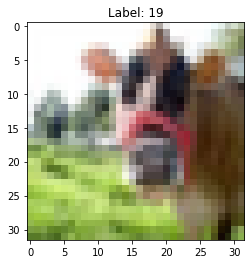

In [205]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the transforms to be applied to the images
transform = transforms.Compose(
    [transforms.ToTensor()] # Normalize with mean and std
)

# Load the training dataset
batch_size = 32
trainset = datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)

# Create a data loader for the training dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False)

# Get one or two images from the training set
image, label = trainset[0]
print(image.shape)
image = image.permute(1, 2, 0)

# Visualize the image
plt.imshow(image, cmap='gray')
plt.title('Label: {}'.format(label))
plt.show()
        
image_size_x = 32
image_size_y = 32 
num_channels = 3


In [206]:
real_datasize = image_size_x*image_size_y*num_channels # a sample in the trainset is a square image of 32*32, and 3 color channels.
input_noise_size = 100;

class UNet(nn.Module):
    def __init__(self, in_channels=3):
        super(UNet, self).__init__()
        
        # Downsample layers
        self.conv1 = DoubleConv(in_channels, 12)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = DoubleConv(12, 24)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = DoubleConv(24, 48)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = DoubleConv(48, 96)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Upsample layers
        self.up5 = nn.ConvTranspose2d(96, 48, kernel_size=2, stride=2)
        self.conv5 = DoubleConv(96, 48)
        self.up6 = nn.ConvTranspose2d(48, 24, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(48, 24)
        self.up7 = nn.ConvTranspose2d(24, 12, kernel_size=2, stride=2)
        self.conv7 = DoubleConv(24, 12)
        
        # Output layer
        self.out = nn.Conv2d(12, in_channels, kernel_size=1)
        
    def forward(self, x):
        # Downsample
        x1 = self.conv1(x)
        x2 = self.pool1(x1)
        #print(f"x2 is {x2.shape}")
        x2 = self.conv2(x2)
        x3 = self.pool2(x2)
        x3 = self.conv3(x3)
        x4 = self.pool3(x3)
        x4 = self.conv4(x4)  
        #print(f"x4 is {x4.shape}")
              
        # Upsample
        x5 = self.up5(x4)
        #print(f"x5 is {x5.shape}")
        #print(f"x3 is {x3.shape}")        
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.conv5(x5)
        x6 = self.up6(x5)
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.conv6(x6)
        x7 = self.up7(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.conv7(x7)
        
        # Output
        out = self.out(x7)
        return out

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Discriminator(nn.Module):
    def __init__(self, num_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(        
                    nn.Conv2d(num_channels, 8, 3, 1, 1),
                    nn.BatchNorm2d(8),
                    nn.Conv2d(8, 16, 3, 2, 1),
                    nn.BatchNorm2d(16),
                    nn.Conv2d(16, 32, 3, 2, 1),
                    nn.BatchNorm2d(32),
                    nn.Conv2d(32, 64, 3, 2, 1),
                    nn.BatchNorm2d(64),
                    nn.Conv2d(64, 128, 3, 2, 1),
                    nn.BatchNorm2d(128),
                    nn.Flatten(),
                    nn.Linear(128 * 2 * 2, 1),
                    nn.LeakyReLU(0.1),
                    nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.model(x)
        return x


# Define the loss function
#criterion = nn.BCELoss()



# Define the optimizers
lr_dis = 0.00001
lr_gen = 0.00005
beta1 = 0.5
beta2 = 0.999

# define the models:
generator = UNet().to(device)
discriminator = Discriminator(num_channels=3).to(device)

# Define the loss function and optimizer for the discriminator
criterion_D = nn.BCELoss()

# Define the loss function and optimizer for the generator
criterion_G = nn.BCELoss()

# Create the generator optimizer
#optimizer_G = torch.optim.SGD(generator.parameters(), lr=lr_gen)
optimizer_G = torch.optim.Adam(generator.parameters(),  lr=lr_gen, betas=(beta1, beta2))



# Create the discriminator optimizer
#optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=lr_dis)
optimizer_D = torch.optim.Adam(generator.parameters(),  lr=lr_dis, betas=(beta1, beta2))


In [207]:
num_epochs = 10
#print("debug chk")
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(trainloader):
        # Train the discriminator
        discriminator.zero_grad()
        real_images = images.to(device)
        #print(f"size of real_images is {real_images.shape}")        
        real_labels = torch.ones(batch_size, 1).to(device)
        noise_input_D = torch.randn(batch_size, 3, 32,32).to(device)
        fake_images = generator(noise_input_D).detach()
        #print(f"size of fake_images is {fake_images.shape}")
        fake_labels = torch.zeros(batch_size, 1).to(device)
        inputchk = discriminator(real_images)
        #print(inputchk.shape)
        discriminator_loss_real = criterion_D(discriminator(real_images), real_labels)
        discriminator_loss_fake = criterion_D(discriminator(fake_images), fake_labels)
        discriminator_loss = discriminator_loss_real + discriminator_loss_fake
        discriminator_loss.backward()
        optimizer_D.step()

        # Train the generator
        generator.zero_grad()
        noise_input_G = torch.randn(batch_size, 3, 32,32).to(device)        
        fake_images = generator(noise_input_G)
        generator_loss = criterion_G(discriminator(fake_images), real_labels)
        generator_loss.backward()
        optimizer_G.step()

        if i % 50 == 0:
            print(f"Iteration {i} Epoch {epoch}: D Loss = {discriminator_loss}, G Loss = {generator_loss} ")
            
        if abs(i-len(trainloader)) <= batch_size:
            break          

Iteration 0 Epoch 0: D Loss = 1.272007942199707, G Loss = 0.6252110600471497 
Iteration 50 Epoch 0: D Loss = 3.287487030029297, G Loss = 0.08548544347286224 
Iteration 100 Epoch 0: D Loss = 4.062033176422119, G Loss = 0.03156347572803497 
Iteration 150 Epoch 0: D Loss = 4.643670082092285, G Loss = 0.019765779376029968 
Iteration 200 Epoch 0: D Loss = 5.057334899902344, G Loss = 0.011656497605144978 
Iteration 250 Epoch 0: D Loss = 5.227982997894287, G Loss = 0.00994342565536499 
Iteration 300 Epoch 0: D Loss = 5.524698734283447, G Loss = 0.0077408840879797935 
Iteration 350 Epoch 0: D Loss = 5.616337776184082, G Loss = 0.005695908330380917 
Iteration 400 Epoch 0: D Loss = 5.756658554077148, G Loss = 0.0059769186191260815 
Iteration 450 Epoch 0: D Loss = 5.935861110687256, G Loss = 0.004710379056632519 
Iteration 500 Epoch 0: D Loss = 6.022060394287109, G Loss = 0.004338124301284552 
Iteration 550 Epoch 0: D Loss = 6.1582112312316895, G Loss = 0.004067323636263609 
Iteration 600 Epoch 0

KeyboardInterrupt: 

In [ ]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 32, 3])


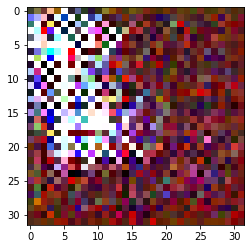

In [232]:

# Generate some images
generator = generator.to("cpu")
with torch.no_grad():
    noise_input_test = torch.randn(1, 3, 32,32)   
    generated_images = generator(noise_input_test)
    image_for_plot = generated_images.squeeze()
    image_for_plot = image_for_plot.permute(1, 2, 0)
print(image_for_plot.shape)
plt.imshow(image_for_plot,cmap='gray')
plt.show()
